Decon + mirror plot

Processing with UniDec: bin15_grads_AB__pos_1__neg_0_negabs_runA_mass.txt → F:\binary\decon\result\bin15_grads_AB__pos_1__neg_0_negabs_runA_mass
Processing with UniDec: bin15_grads_AB__pos_1__neg_0_negabs_runB_mass.txt → F:\binary\decon\result\bin15_grads_AB__pos_1__neg_0_negabs_runB_mass
Processing with UniDec: bin15_grads_AB__pos_1__neg_0_pos_runA_mass.txt → F:\binary\decon\result\bin15_grads_AB__pos_1__neg_0_pos_runA_mass
Processing with UniDec: bin15_grads_AB__pos_1__neg_0_pos_runB_mass.txt → F:\binary\decon\result\bin15_grads_AB__pos_1__neg_0_pos_runB_mass
Processing with UniDec: bin5_grads_AB__pos_1__neg_0_negabs_runA_mass.txt → F:\binary\decon\result\bin5_grads_AB__pos_1__neg_0_negabs_runA_mass
Processing with UniDec: bin5_grads_AB__pos_1__neg_0_negabs_runB_mass.txt → F:\binary\decon\result\bin5_grads_AB__pos_1__neg_0_negabs_runB_mass
Processing with UniDec: bin5_grads_AB__pos_1__neg_0_pos_runA_mass.txt → F:\binary\decon\result\bin5_grads_AB__pos_1__neg_0_pos_runA_mass
Processin

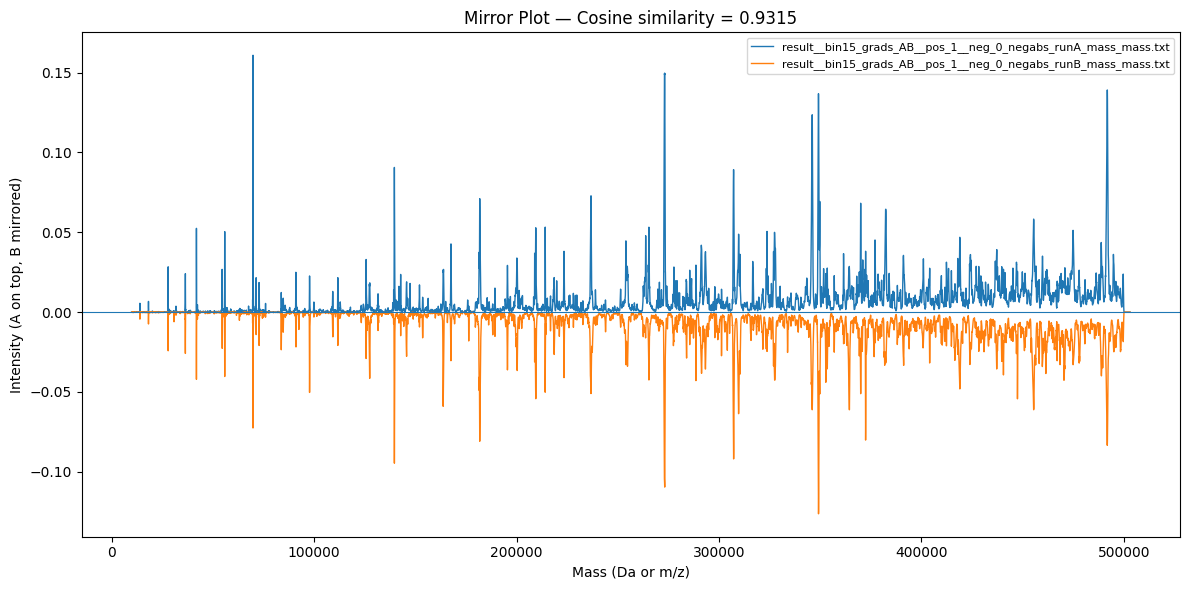


Files used:
 A: F:\binary\decon\result\result__bin15_grads_AB__pos_1__neg_0_negabs_runA_mass_mass.txt
 B: F:\binary\decon\result\result__bin15_grads_AB__pos_1__neg_0_negabs_runB_mass_mass.txt
Cosine similarity: 0.931513
Saved PNG: F:\binary\decon\mirror_result__bin15_grads_AB__pos_1__neg_0_negabs_runA_mass_mass__vs__result__bin15_grads_AB__pos_1__neg_0_negabs_runB_mass_mass.png
Saved CSV: F:\binary\decon\aligned_result__bin15_grads_AB__pos_1__neg_0_negabs_runA_mass_mass__vs__result__bin15_grads_AB__pos_1__neg_0_negabs_runB_mass_mass.csv


In [1]:
# -*- coding: utf-8 -*-
import os
import glob
import shutil
import tempfile
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ====================== USER CONFIG ======================
ROOT_FOLDER = r"F:\binary\decon"           # Folder with the TWO input files (top-level)
RESULT_SUBFOLDER = "result"          # Where UniDec writes per-file subfolders
PLOT_OUT_DIR = r"F:\binary\decon"    # Where to save mirror PNG + aligned CSV

# Optional: set a mass window to zoom (min_mass, max_mass); or None to plot all
MASS_WINDOW = None  # e.g., (14000, 16000)

# Optional: normalize intensities BEFORE computing cosine (doesn't affect plot)
NORMALIZE_FOR_COSINE = False
# ========================================================


def _unique_dst_path(dst_dir, fname):
    """Return a unique path in dst_dir for fname, adding a numeric suffix if needed."""
    base, ext = os.path.splitext(fname)
    candidate = os.path.join(dst_dir, fname)
    i = 1
    while os.path.exists(candidate):
        candidate = os.path.join(dst_dir, f"{base}__{i}{ext}")
        i += 1
    return candidate


def _prefixed_name(src_path, result_root):
    """
    Build a safer filename using the immediate parent folder under result/ as a prefix
    to reduce collisions: e.g., result/sampleA/sampleA_mass.txt -> sampleA__sampleA_mass.txt
    """
    parent = os.path.basename(os.path.dirname(src_path))
    fname = os.path.basename(src_path)
    return f"{parent}__{fname}" if parent and parent != result_root else fname


def run_unidec_on_folder(folder_path, result_root):
    """Run UniDec on each top-level file in folder_path, outputting into result_root/<basename>."""
    os.makedirs(result_root, exist_ok=True)

    # Loop through top-level files only
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if not os.path.isfile(file_path):
            continue

        base_name = os.path.splitext(file_name)[0]
        file_result_folder = os.path.join(result_root, base_name)
        os.makedirs(file_result_folder, exist_ok=True)

        print(f"Processing with UniDec: {file_name} → {file_result_folder}")
        # NOTE: Ensure 'unidec' python module/CLI is installed & callable
        subprocess.run(
            ["python", "-m", "unidec", "-f", file_path, "-o", file_result_folder],
            check=False
        )

    print("✅ UniDec run complete. Raw results under:", result_root)


def collect_mass_txt_flat(result_root):
    """
    Collect all *_mass.txt files from subfolders into a flat, clean result_root.
    Returns the list of final collected file paths inside result_root.
    """
    # 1) Find *_mass.txt (recursively)
    collected = []
    for root, _, files in os.walk(result_root):
        for f in files:
            if f.endswith("_mass.txt"):
                collected.append(os.path.join(root, f))

    if not collected:
        print("⚠️ No *_mass.txt files found under:", result_root)
        return []

    # 2) Stage to a temp dir first
    temp_dir = tempfile.mkdtemp(prefix="mass_collect_")
    staged = []
    for src in collected:
        try:
            safe_name = _prefixed_name(src, result_root)
            dst = _unique_dst_path(temp_dir, os.path.basename(safe_name))
            print(f"Staging: {src} → {dst}")
            shutil.copy2(src, dst)
            staged.append(dst)
        except Exception as e:
            print(f"⚠️ Skip (copy error): {src} — {e}")

    # 3) Clean the result_root completely
    for item in os.listdir(result_root):
        item_path = os.path.join(result_root, item)
        if os.path.abspath(item_path) == os.path.abspath(temp_dir):
            # Just in case temp_dir somehow is inside result_root (shouldn't be)
            continue
        try:
            if os.path.isfile(item_path) or os.path.islink(item_path):
                os.remove(item_path)
            else:
                shutil.rmtree(item_path)
        except Exception as e:
            print(f"⚠️ Could not remove {item_path}: {e}")

    # 4) Move staged files back into a clean result_root
    final_paths = []
    for s in staged:
        try:
            final_dst = _unique_dst_path(result_root, os.path.basename(s))
            print(f"Finalizing: {s} → {final_dst}")
            shutil.move(s, final_dst)
            final_paths.append(final_dst)
        except Exception as e:
            print(f"⚠️ Move error for {s}: {e}")

    # 5) Remove temp dir
    try:
        shutil.rmtree(temp_dir)
    except Exception:
        pass

    print("📂 Clean result folder ready with only *_mass.txt files:", result_root)
    return sorted(final_paths)


# ---------------- Mirror-plot utilities ----------------
def load_two_col_flexible(path):
    """
    Auto-detect delimiter (comma/semicolon/whitespace). If only one column is found,
    treat as intensity-only and generate a mass index (0..N-1).
    Uses first two columns as [mass, intensity].
    """
    df = pd.read_csv(path, sep=r"[,\s;]+", header=None, engine="python")
    if df.shape[1] == 1:
        df.columns = ["intensity"]
        df.insert(0, "mass", np.arange(len(df)))
    else:
        df = df.iloc[:, :2].copy()
        df.columns = ["mass", "intensity"]

    df["mass"] = pd.to_numeric(df["mass"], errors="coerce")
    df["intensity"] = pd.to_numeric(df["intensity"], errors="coerce").fillna(0.0)
    df = df.dropna(subset=["mass"]).sort_values("mass").reset_index(drop=True)
    return df


def align_on_mass(dfA, dfB):
    merged = pd.merge(dfA, dfB, on="mass", how="outer", suffixes=("_A", "_B"))
    return merged.fillna(0.0).sort_values("mass").reset_index(drop=True)


def cosine_similarity(a, b, eps=1e-12):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if NORMALIZE_FOR_COSINE:
        na = np.linalg.norm(a) + eps
        nb = np.linalg.norm(b) + eps
        a, b = a / na, b / nb
    num = float(np.dot(a, b))
    den = float(np.linalg.norm(a)) * float(np.linalg.norm(b)) + eps
    return num / den


def plot_mirror(merged, label_a, label_b, cos_sim, out_png):
    x = merged["mass"].values
    yA = merged["intensity_A"].values
    yB = merged["intensity_B"].values

    if MASS_WINDOW is not None:
        lo, hi = MASS_WINDOW
        msk = (x >= lo) & (x <= hi)
        x, yA, yB = x[msk], yA[msk], yB[msk]

    plt.figure(figsize=(12, 6))
    plt.plot(x, yA, linewidth=1.0, label=label_a)
    plt.plot(x, -yB, linewidth=1.0, label=label_b)
    plt.axhline(0, linewidth=0.8)
    plt.xlabel("Mass (Da or m/z)")
    plt.ylabel("Intensity (A on top, B mirrored)")
    plt.title(f"Mirror Plot — Cosine similarity = {cos_sim:.4f}")
    plt.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()


def pick_two_files(result_root):
    """
    Pick two *_mass.txt files from a flat result_root. If more than two exist,
    prefer names containing 'runa'/'runb' (case-insensitive), else first two sorted.
    """
    txts = sorted(glob.glob(os.path.join(result_root, "*_mass.txt")))
    if len(txts) < 2:
        raise SystemExit(f"Need two *_mass.txt files in '{result_root}'. Found {len(txts)}.")
    lowmap = {os.path.basename(t).lower(): t for t in txts}
    a = next((p for n, p in lowmap.items() if "runa" in n), None)
    b = next((p for n, p in lowmap.items() if "runb" in n), None)
    return [a, b] if a and b else txts[:2]


def main():
    result_root = os.path.join(ROOT_FOLDER, RESULT_SUBFOLDER)
    os.makedirs(PLOT_OUT_DIR, exist_ok=True)

    # 1) Run UniDec over the two input files in ROOT_FOLDER
    run_unidec_on_folder(ROOT_FOLDER, result_root)

    # 2) Flatten/collect only *_mass.txt into a clean result_root
    collected = collect_mass_txt_flat(result_root)
    if len(collected) < 2:
        raise SystemExit("❌ Could not find two mass files to compare after collection.")

    # 3) Choose the pair to plot
    file_a, file_b = pick_two_files(result_root)
    baseA = os.path.splitext(os.path.basename(file_a))[0]
    baseB = os.path.splitext(os.path.basename(file_b))[0]

    out_png = os.path.join(PLOT_OUT_DIR, f"mirror_{baseA}__vs__{baseB}.png")
    out_csv = os.path.join(PLOT_OUT_DIR, f"aligned_{baseA}__vs__{baseB}.csv")

    # 4) Load, align, cosine, plot
    A = load_two_col_flexible(file_a)
    B = load_two_col_flexible(file_b)
    merged = align_on_mass(A, B)

    cos_sim = cosine_similarity(
        merged["intensity_A"].to_numpy(),
        merged["intensity_B"].to_numpy()
    )

    plot_mirror(merged, os.path.basename(file_a), os.path.basename(file_b), cos_sim, out_png)

    # 5) Save aligned table
    merged.to_csv(out_csv, index=False)

    print("\nFiles used:")
    print(" A:", file_a)
    print(" B:", file_b)
    print(f"Cosine similarity: {cos_sim:.6f}")
    print("Saved PNG:", os.path.abspath(out_png))
    print("Saved CSV:", os.path.abspath(out_csv))


if __name__ == "__main__":
    main()
